# Navigation

### 1. Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3 Train the Agent

In [5]:
# Here I chose to use Double Q-Learning to prevent overestimation of Q-values

# from DQN import Agent
from DQN import DAgent

agent = DAgent(state_size=state_size, action_size=action_size, seed=1, hidden_layers=[64, 32], 
                  tau=0.001, learning_rate=0.0005, update_every=4)

In [6]:
import numpy as np
from collections import deque

In [7]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    '''train agent'''
    
#     n_episodes (int): maximum number of training episodes
#     max_t (int): maximum number of timesteps per episode
#     eps_start (float): starting value of epsilon, for epsilon-greedy action selection
#     eps_end (float): minimum value of epsilon
#     eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores    

In [8]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
scores = train()

Episode 100	Average Score: 0.88
Episode 200	Average Score: 4.43
Episode 300	Average Score: 7.52
Episode 400	Average Score: 11.04
Episode 488	Average Score: 13.10
Environment solved in 388 episodes!	Average Score: 13.10


### 4. Check Stats

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

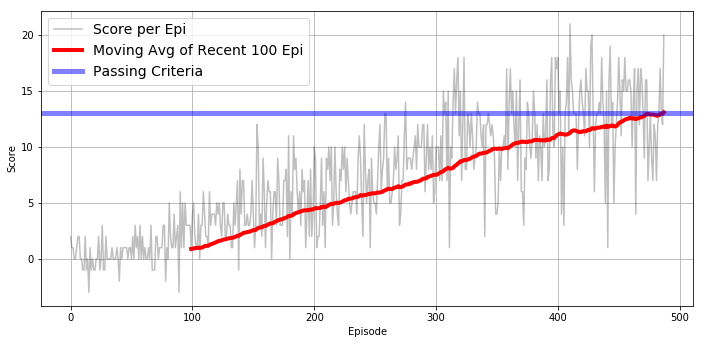

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
plt.rcParams.update({'font.size': 14})

scores_rolling = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(scores_rolling, "-", c="red", linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(13, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score per Epi", "Moving Avg of Recent 100 Epi", "Passing Criteria"])

fig.tight_layout()
fig.savefig("stats.jpg")